# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [19]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

In [20]:
#reading in an image
images = [cv2.imread(file) for file in glob.glob("path/to/files/*.png")]

image1 = mpimg.imread('test_images/solidWhiteRight.jpg')
image2 = mpimg.imread('test_images/solidYellowLeft.jpg')
image3 = mpimg.imread('test_images/solidWhiteCurve.jpg')
image4 = mpimg.imread('test_images/solidYellowCurve.jpg')
image5 = mpimg.imread('test_images/solidYellowCurve2.jpg')
image6 = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')

In [21]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    m_positive = []
    m_negative = []
    b_positive = []
    b_negative = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
        
            if (x2-x1) == 0:
                pass
            else:
                m = (y2-y1)/ (x2-x1) #calculate slope
                b = y1 - x1*m        #calculate intercept
                
            #Distnguish slope and intercept of Hough lines to left line and right line
                if m > 0:
                    m_positive.append(m)
                    b_positive.append(b)


                elif m < 0:
                    m_negative.append(m)
                    b_negative.append(b)
                    
                #find the average slope and intercept of the right and left lines  
         
    right_m = np.mean(m_negative)
    right_b = np.mean(b_negative)       
    left_m = np.mean(m_positive)
    left_b = np.mean(b_positive)
   

                #find right and left lines' points
    if right_m != 0:
        ymin_right = img.shape[0]
        xmin_right = (ymin_right - right_b)/ right_m
        ymax_right = 340
        xmax_right = (ymax_right - right_b)/ right_m
    if left_m != 0:  
        ymin_left = img.shape[0]
        xmin_left = (ymin_left - left_b)/ left_m
        ymax_left =340
        xmax_left = (ymax_left - left_b)/ left_m
    
        right_minPoint = (int(xmin_right), ymin_right)
        right_maxPoint = (int(xmax_right), ymax_right)
        left_minPoint = (int(xmin_left), ymin_left)
        left_maxPoint = (int(xmax_left), ymax_left)

        cv2.line(img, right_minPoint, right_maxPoint, color, thickness) #draw solid line (right)
        cv2.line(img, left_minPoint, left_maxPoint, color, thickness) #draw solid line (left)

   
            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Build a Lane Finding Pipeline



## Test Images

In [22]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [23]:
def process_image(img):
    
    # 
    low_threshold = 100
    high_threshold = 200
    kernel_size = 3
    vertices = np.array([[(70,img.shape[0]),(400,320), (500, 320), (900,img.shape[0])]], dtype=np.int32)
    rho = 2
    theta = np.pi/180
    threshold = 55
    min_line_len = 10
    max_line_gap = 5
    
    can = canny(gaussian_blur(grayscale(img), kernel_size), low_threshold, high_threshold) #apply canny function
    
    masked = region_of_interest(can, vertices) #apply region_of_interest function to get masked image
    
    h = hough_lines(masked, rho, theta, threshold, min_line_len, max_line_gap) #apply hough_lines function to get 
    
    result = weighted_img(h, img, α=0.8, β=1., γ=0.)

    
    return result
#save output images in test_images_output
cv2.imwrite('test_images_output/img1.jpg',process_image(image1)) 
cv2.imwrite('test_images_output/img2.jpg',process_image(image2)) 
cv2.imwrite('test_images_output/img3.jpg',process_image(image3)) 
cv2.imwrite('test_images_output/img4.jpg',process_image(image4)) 
cv2.imwrite('test_images_output/img5.jpg',process_image(image5)) 
cv2.imwrite('test_images_output/img6.jpg',process_image(image6)) 


SyntaxError: invalid syntax (<ipython-input-23-307153281b1a>, line 25)

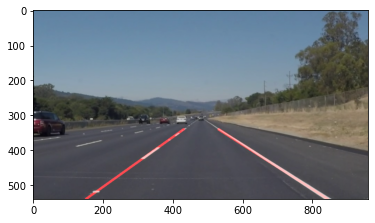

In [7]:
plt.imshow(process_image(image1)) #show output image1

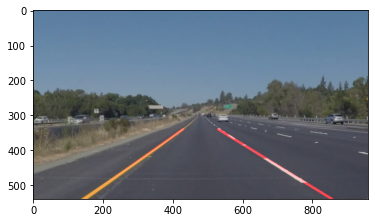

In [8]:
plt.imshow(process_image(image2)) #show output image2

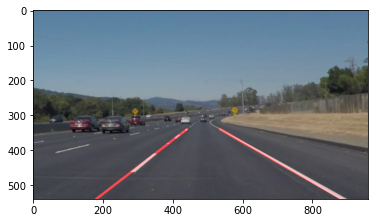

In [9]:
plt.imshow(process_image(image3)) #show output image3

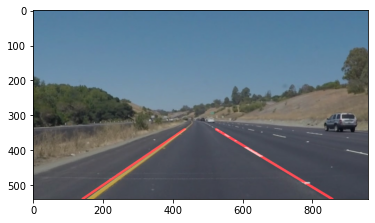

In [10]:
plt.imshow(process_image(image4)) #show output image4

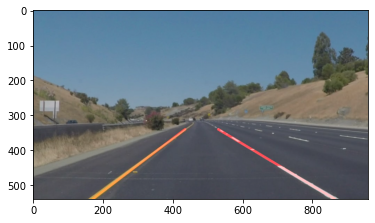

In [11]:
plt.imshow(process_image(image5)) #show output image5

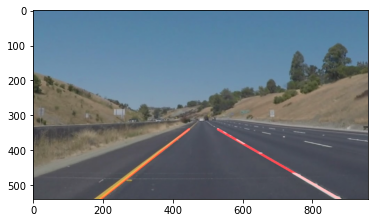

In [12]:
plt.imshow(process_image(image6)) #show output image6

## Test on Videos

### Test video 1 (solid white lane on the right)

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [14]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
Wall time: 6.48 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Test Video 2 (solid yellow lane on the left)

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   0%|▏                                                                    | 2/681 [00:00<00:43, 15.65it/s, now=None]

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
Wall time: 16.9 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))